# Notebook
Notebook for prototyping and experimenting. 

### New Simulation Config


In [ ]:

beam_settings = load_beam_config(config["beam"])

lenses = [load_lens_config(lc) for lc in config["lenses"]]
stages = [load_sim_stage_config(sc) for sc in config["stages"]]

options = generate_simulation_options(config, "log")
parameters = generate_simulation_parameters(config)


sim_config = SimulationConfig(
    beam=beam_settings,
    lenses=lenses,
    stages=stages,
    parameters=parameters,
    options=options
)


print("SIM CONFIG:")
pprint(sim_config.beam)
print("-"*50)
pprint(sim_config.lenses)
print("-"*50)
pprint(sim_config.stages)
print("-"*50)
pprint(sim_config.parameters)
print("-"*50)
pprint(sim_config.options)



### DASK Experiments


In [ ]:
import time
import dask


@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1

@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [ ]:
%%time

a = inc(1)
b = inc(1)
c = add(a, b)
c.visualize("mydask.png")
# c.dask
# c = c.compute()


In [ ]:
import zarr

arr = zarr.ones(shape=(100, 10000, 10000))

import dask.array as da

darr = da.from_zarr(arr) * np.arange(arr.shape[1])

import matplotlib.pyplot as plt

plt.imshow(darr[0, :, :])
plt.show()

### Custom Config

Load a custom config from key (allows for sweeping configs)


In [ ]:
%load_ext autoreload
%autoreload 2
from lens_simulation import utils, validation, Simulation, SimulationRunner
from pprint import pprint

from lens_simulation.Lens import generate_lens
from lens_simulation.Medium import Medium

config = utils.load_config("config_minimum.yaml")
config["log_dir"] = "log"


sim_runner = SimulationRunner.SimulationRunner("config.yaml")
sim_runner.setup_simulation()

conf_1 = sim_runner.simulation_configurations[0]
for conf in sim_runner.simulation_configurations:

    pprint(conf)
    print("------------ AFTER -------------- ")
    sim = Simulation.Simulation(conf)


### Mega Stack
Stack multiple simulations together for synchronised visualisation


In [ ]:
%load_ext autoreload
%autoreload 2


# TODO: stage stacking


from lens_simulation import utils, plotting
import matplotlib.pyplot as plt
import numpy as np

import dask.array as da

paths = [
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\active-shark",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\fit-jennet",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\moral-skink"
    ]

mega = None
for p in paths:

    sim = plotting.load_full_sim_propagation_v2(p)

    if mega is None:
        mega = sim
    else: 
        mega = np.hstack([mega, sim])
    
    print("sim shape: ", sim.shape)
    print("mega shape: ", mega.shape)


print("final: ", mega.shape)

mega_view = plotting.slice_simulation_view(mega)



In [ ]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
import matplotlib.pyplot as plt
import numpy as np

import dask.array as da
import os

paths = [
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\active-shark",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\fit-jennet",
    r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\weekly-famous-lizard\moral-skink"
    ]

data = []
for p in paths:
    print(f"load sim_{os.path.basename(p)}")
    sim = plotting.load_full_sim_propagation_v2(p)

    data.append(da.from_array(sim))
    
    # print("sim shape: ", sim.shape)
    # print("mega shape: ", mega.shape)

#
mega = da.concatenate(data, axis=1)

print("final: ", mega.shape)

mega_view = plotting.slice_simulation_view(mega)

In [ ]:
import napari
from magicgui import magicgui
from napari.layers import Image
from napari.types import ImageData

# create a viewer and add some images
viewer = napari.Viewer()
viewer.add_image(mega, name="simulation", colormap="turbo", scale=[1, 0.1, 0.1])

# turn the gaussian blur function into a magicgui
# for details on why the `-> ImageData` return annotation works:
# https://napari.org/guides/magicgui.html#return-annotations
@magicgui(
    # tells magicgui to call the function whenever a parameter changes
    auto_call=True,
    # `widget_type` to override the default (spinbox) "float" widget
    prop={"widget_type": "FloatSlider", "max": 1.0},
    axis={"choices": [0, 1, 2]},
    layout="horizontal",
)
def slice_image(layer: Image, prop: float = 0.5, axis: int = 0) -> ImageData:
    """Slice the volume along the selected axis"""
    if layer:
        return plotting.slice_simulation_view(layer.data, axis=axis, prop=prop)

# Add it to the napari viewer
# viewer.window.add_dock_widget(slice_image, area="bottom")

napari.run()

## Gaussian Beam


In [ ]:
# TODO


## Electric Field Refactor
Restructure the simulation to use electric field propagation rather than lenses



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sim: whole-maggot (d1062f4e7f) - Plotting Simulation:   0%|          | 0/2 [00:08<?, ?it/s]  WARNING:imageio:Lossy conversion from float32 to uint8. Range [0.0, 1492689577050112.0]. Convert image to uint8 prior to saving to suppress this warning.
Sim: whole-maggot (d1062f4e7f) - Plotting Simulation:  50%|█████     | 1/2 [00:19<00:12, 12.78s/it]  WARNING:imageio:Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


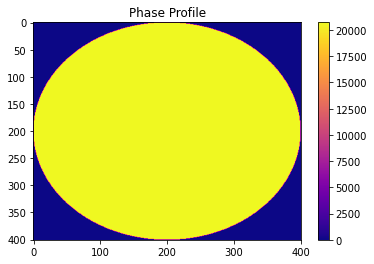

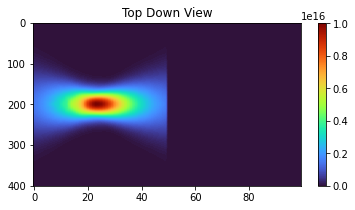

In [4]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting
from lens_simulation.beam import generate_beam
from lens_simulation.Simulation import (generate_beam_simulation_stage, generate_simulation_parameters, 
    generate_sq_freq_arr, propagate_over_distance)
from lens_simulation import Simulation
from pprint import pprint
from lens_simulation.Lens import Lens
from scipy import fftpack
from lens_simulation.structures import SimulationStage, SimulationParameters, SimulationOptions, SimulationResult
from tqdm import tqdm
import numpy as np
import zarr
import matplotlib.pyplot as plt

path = "test"
config = utils.load_config("example/sim_gaussian_2d.yaml")
config["log_dir"] = "log"

sim = Simulation.Simulation(config)
sim.run_simulation()

fig = plotting.plot_sim_propagation_v2(sim.options.log_dir)
plt.show()


In [ ]:
from lens_simulation.beam import create_gaussian

path = "test"
config = utils.load_config("example/sim_gaussian_2d.yaml")
config["log_dir"] = path

parameters = generate_simulation_parameters(config)
beam_stage = generate_beam_simulation_stage(config, parameters)

z0 = -0.e-3
r0 = (0, 0)
w0 = 40.e-3

# parameters.sim_wavelength = 30e-3
arr = create_gaussian(r0, w0, z0, parameters=parameters, theta=0, phi=0)

print(parameters)

plt.imshow(np.abs(arr), cmap="turbo", aspect="auto")
plt.title("Gaussian")
plt.colorbar()
plt.show()

plt.imshow(beam_stage.lens.profile, cmap="turbo")
plt.title("Beam Profile")
plt.colorbar()
plt.show()
